In [22]:
import pandas as pd

# Load CSV files
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

# Display the first few rows of each dataframe
train_df.head(), test_df.head()


(              filename     start       end        class
 0  nips4b_train001.wav  2.975057  3.172426  Petpet_song
 1  nips4b_train001.wav  1.967891  2.054966  Sylcan_song
 2  nips4b_train001.wav  0.856236  0.937506  Sylcan_song
 3  nips4b_train001.wav  1.541224  1.674739  Sylcan_song
 4  nips4b_train001.wav  1.843084  1.973696  Sylcan_song,
              filename
 0  nips4b_test001.wav
 1  nips4b_test002.wav
 2  nips4b_test003.wav
 3  nips4b_test004.wav
 4  nips4b_test005.wav)

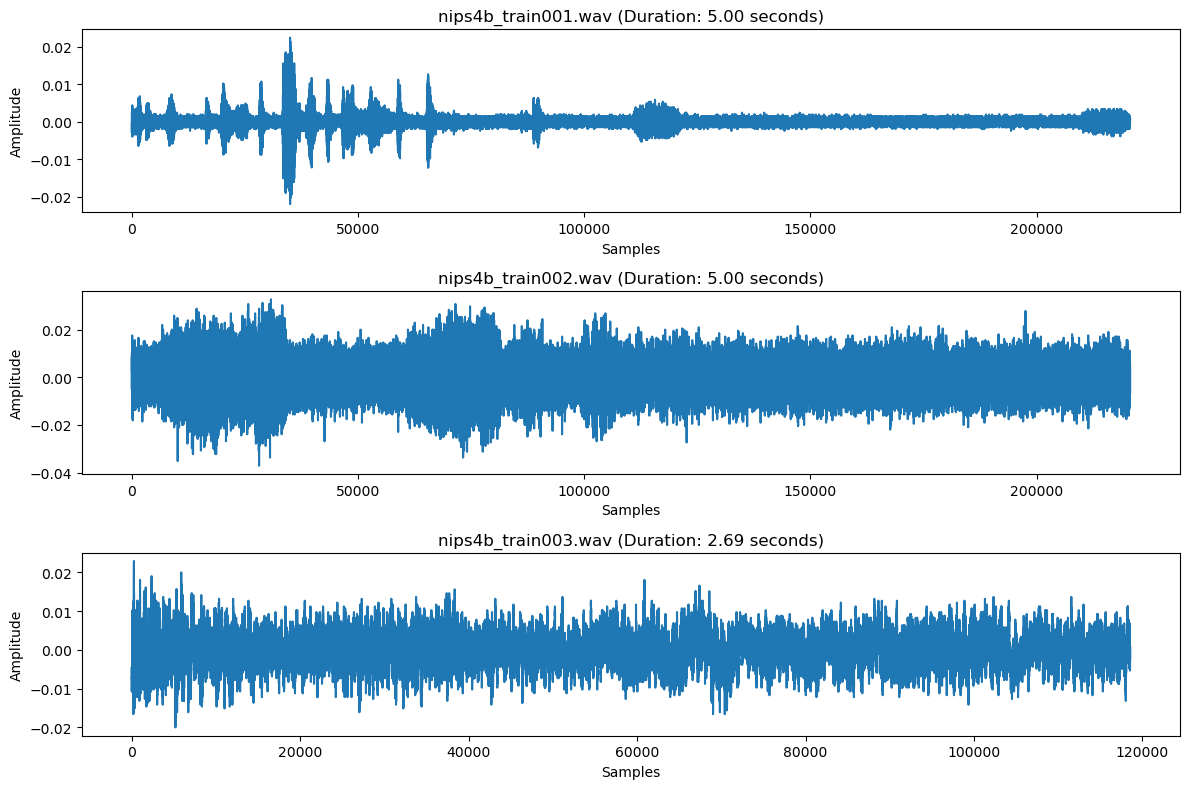

In [23]:
import os
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt

# Load a few audio samples
audio_files = ["nips4b_train001.wav", "nips4b_train002.wav", "nips4b_train003.wav"]
audio_data = {}

train_audio_folder = 'data/train/'
for file in os.listdir(train_audio_folder):
    waveform, sample_rate = torchaudio.load(f"data/train/{file}")
    audio_data[file] = {
        "waveform": waveform,
        "sample_rate": sample_rate,
        "duration": waveform.shape[1] / sample_rate
    }

# Visualize the waveforms
fig, axes = plt.subplots(len(audio_files), 1, figsize=(12, 8))
for ax, (filename, data) in zip(axes, audio_data.items()):
    ax.plot(data["waveform"].t().numpy())
    ax.set_title(f"{filename} (Duration: {data['duration']:.2f} seconds)")
    ax.set_xlabel("Samples")
    ax.set_ylabel("Amplitude")
plt.tight_layout()
plt.show()


c:\Users\danil\.conda\envs\pytorch-gpu-python-3-10\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


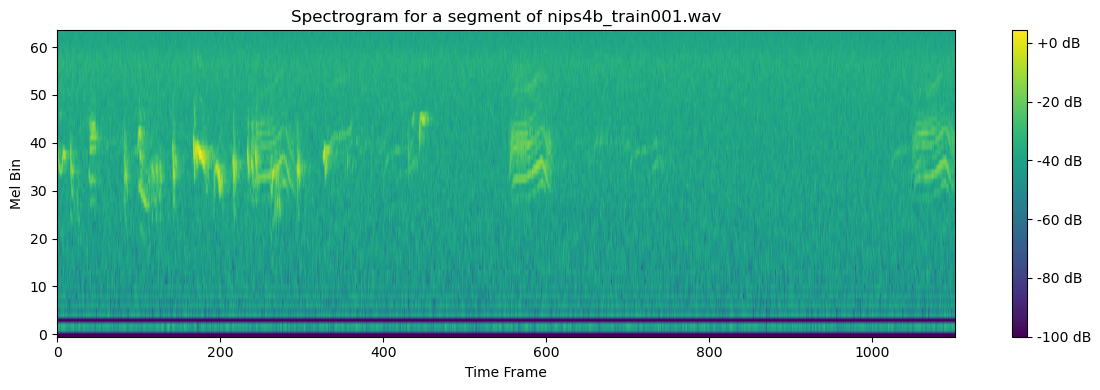

In [24]:
# Define constants for preprocessing
CHUNK_SIZE = 5  # chunk size in seconds
HOP_SIZE = 2.5  # hop size in seconds
N_MELS = 64  # number of mel bins for the spectrogram

# Function to segment an audio file into fixed-length chunks
def segment_audio(waveform, sample_rate, chunk_size, hop_size):
    num_samples_per_chunk = int(chunk_size * sample_rate)
    hop_size_samples = int(hop_size * sample_rate)
    chunks = []
    
    start_sample = 0
    end_sample = num_samples_per_chunk
    
    while end_sample < waveform.shape[1]:
        chunks.append(waveform[:, start_sample:end_sample])
        start_sample += hop_size_samples
        end_sample += hop_size_samples
    
    return chunks

# Function to generate spectrograms from audio chunks
def generate_spectrograms(audio_data, n_mels):
    mel_spectrogramer = T.MelSpectrogram(sample_rate=audio_data["sample_rate"], n_mels=n_mels)
    spectrograms = []
    
    for chunk in audio_data["chunks"]:
        mel_spectrogram = mel_spectrogramer(chunk)
        mel_spectrogram_db = T.AmplitudeToDB()(mel_spectrogram)
        spectrograms.append(mel_spectrogram_db)
    
    return spectrograms

# Segment audio and generate spectrograms
for filename, data in audio_data.items():
    chunks = segment_audio(data["waveform"], data["sample_rate"], CHUNK_SIZE, HOP_SIZE)
    audio_data[filename]["chunks"] = chunks
    audio_data[filename]["spectrograms"] = generate_spectrograms(audio_data[filename], N_MELS)

# Visualize a spectrogram for demonstration
plt.figure(figsize=(12, 4))
plt.imshow(audio_data["nips4b_train001.wav"]["spectrograms"][0][0].numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram for a segment of nips4b_train001.wav")
plt.xlabel("Time Frame")
plt.ylabel("Mel Bin")
plt.tight_layout()
plt.show()

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BirdCallNet(nn.Module):
    def __init__(self, num_classes=89):
        super(BirdCallNet, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        # Max-pooling layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        # Dropout layer
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # First conv block
        x = self.pool(F.relu(self.conv1(x)))
        
        # Second conv block
        x = self.pool(F.relu(self.conv2(x)))
        
        # Third conv block
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten the tensor
        x = x.view(-1, 64 * 8 * 16)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        # Since it's a multi-label task, we use sigmoid activation
        x = torch.sigmoid(x)
        
        return x

# Create an instance of the model
model = BirdCallNet()
model


BirdCallNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=89, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [26]:
from sklearn.preprocessing import MultiLabelBinarizer

# Convert the labels in train.csv into a binary matrix format

# Group by filename and aggregate the classes
grouped = train_df.groupby("filename")["class"].apply(list).reset_index()

# Use MultiLabelBinarizer to convert class lists into a binary matrix
mlb = MultiLabelBinarizer()
binary_labels = mlb.fit_transform(grouped["class"])

# Convert the binary matrix into a DataFrame
labels_df = pd.DataFrame(binary_labels, columns=mlb.classes_)

# Merge with the filename
labeled_data_df = pd.concat([grouped["filename"], labels_df], axis=1)

labeled_data_df.head(10)


,filename,Aegcau_call,Alaarv_song,Anttri_song,Butbut_call,Carcan_call,Carcan_song,Carcar_call,Carcar_song,Cerbra_call,...,Sylund_call,Sylund_song,Tetpyg_song,Tibtom_song,Trotro_song,Turmer_call,Turmer_song,Turphi_call,Turphi_song,Unknown
0,nips4b_train001.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,nips4b_train002.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,nips4b_train003.wav,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,nips4b_train004.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,nips4b_train005.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,nips4b_train006.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,nips4b_train007.wav,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7,nips4b_train008.wav,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,nips4b_train009.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,nips4b_train010.wav,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
from torch.utils.data import Dataset, DataLoader

class BirdCallDataset(Dataset):
    def __init__(self, audio_data, labels_df=None):
        self.audio_data = audio_data
        self.labels_df = labels_df
        self.mlb = MultiLabelBinarizer()
        if labels_df is not None:
            self.labels = self.mlb.fit_transform(self.labels_df.set_index('filename')['class'].apply(list))

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, idx):
        filename = list(self.audio_data.keys())[idx]
        spectrograms = self.audio_data[filename]['spectrograms']
        # Return the first spectrogram chunk as example, you can expand this to utilize all chunks.
        spectrogram = spectrograms[0]
        if self.labels_df is not None:
            label = self.labels[idx]
            return spectrogram, torch.FloatTensor(label)
        return spectrogram

train_dataset = BirdCallDataset(audio_data, labeled_data_df)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


KeyError: 'class'

In [ ]:
import torch.optim as optim

device = torch.device('cpu')  # using CPU as CUDA isn't available
model = BirdCallNet().to(device)
criterion = nn.BCEWithLogitsLoss()  # Sigmoid + Binary cross-entropy combined
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)
        
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


In [ ]:
test_audio_data = {}
test_audio_folder = 'data/test/'
for file in os.listdir(test_audio_folder):
    waveform, sample_rate = torchaudio.load(f"data/test/{file}")
    audio_data = {
        "waveform": waveform,
        "sample_rate": sample_rate
    }
    chunks = segment_audio(waveform, sample_rate, CHUNK_SIZE, HOP_SIZE)
    audio_data["chunks"] = chunks
    audio_data["spectrograms"] = generate_spectrograms(audio_data, N_MELS)
    test_audio_data[file] = audio_data

test_dataset = BirdCallDataset(test_audio_data)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


IndexError: list index out of range

In [ ]:
def predict(model, dataloader):
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for inputs in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions = torch.round(outputs)  # Threshold at 0.5
            all_predictions.extend(predictions.cpu().numpy())
            
    return all_predictions

test_predictions = predict(model, test_loader)
